# Table of Content
___
## 0. Loading the Needed Libraries
## 1. Problem Description and Dataset
#### 1.1 Problem Description and Goal
#### 1.2 The Dataset
___
## 2. Exploratory Data Analysis
#### 2.1 A general look at the Tweets' text
##### 2.1.1 The distributions of the Tweets' Length
##### 2.1.2 The distribution of the number of words 
##### 2.1.3 Looking at the Stop Words
##### 2.1.4 Looking at the most repeated words
#### 2.2 The Location of Tweets
#### 2.3 The Keywords column 
___
## 3. Building Baseline Models
####  3.1 RidgeClassifier Following Kaggle Tutorial
#### 3.2 Multinomial Naive Bayes Classifier
#### 3.3 Random Forrest Classifier
#### 3.4 Logistic Regression
#### 3.5 SVM
#### 3.6 Gradient Boosting Classifier
#### 3.7 KNN
#### 3.8 XGBoost Classifier
___
## 4. Data Cleaning
___
## 5. Approach I: Basic Processing Methods
#### 5.1 Removing  stopwords
#### 5.2 N-Grams parameter
#### 5.3 Mislabeled entries
#### 5.4 Using the Keyword column to improve the performance
#### 5.5 Conclusion Approach I
___
## 6. Approach II: Tokenization, Stemming, Lemmatization and  TF - IDF
#### 6.1 Pre-cleaning
#### 6.2 Tokenization, Stemming, and Lematization
#### 6.3 Including the keywords into the text
#### 6.4 TF - IDF
#### 6.5 Running a SVM model with GridSearch
#### 6.6 Running a Logistic Regression model with Hyperparameter tunning
#### 6.7 Adding the words embeddings
#### 6.8 Trying POS Tagging
#### 6.9 Discussion: the better approach for considering the Keywords
___
## 7. Approach III: Better Preprocessing with correction of Spelling Mistakes
#### 7.1 Running the Correct Spelling Function on the data
#### 7.2 Rerunning the models with the correct spelling
##### 7.2.1 Model 1 Rerun with spelling corrected
___
## 8. Approach IV: Simple BERT implementation using the simpletransformers library
#### 8.1 BERT Model on raw data 
#### 8.2 BERT Model on cleaner data 
#### 8.3 BERT Model on cleaned and normalized data
#### 8.4 BERT Model on cleaned, normalized and relabeled data
#### 8.5 BERT Model on data corrected for spelling mistakes
#### 8.6 BERT Model on corrected spelling mistakes and normalized data
#### 8.7 BERT Model with spelling corrected, with stop words, and lemmatized
___
## 9. Conlusions and Final Model chosen
___
___

In [1057]:
# Basic libraries:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('ggplot')

# NLTK:
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
stop=set(stopwords.words('english'))

#from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

# sklearn: 
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, confusion_matrix, f1_score
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Keras: 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

# tensorflow:
import tensorflow_hub as hub

# Other:
from scipy import sparse
import re
import string
from tqdm import tqdm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from spellchecker import SpellChecker

import torch

# simpletransformers:
from simpletransformers.classification import ClassificationModel


# Function to find the correlation between categorical variables
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")
font = {'fontname':'Arial Narrow'}

## 1. Problem Description and Dataset

### 1.1 Problem Description and Goal

The goal of this notebook is to build a machine learning model that is able to classify the topic in a dataset containing 10,000 Tweets. In particular, we want to predict which Tweets in our dataset are about real disasters and which ones are not. 

This problem is actually a Kaggle Competition that can be found in the following link: https://www.kaggle.com/c/nlp-getting-started/overview

### 1.2 The Dataset

We are given 3 different files:

- **train.csv** : the training data
- **test.csv** : the test data
- **sample_submission.csv** : a sample submission file showing the correct format

Both the training and testing data have the following information: the text of a tweet, a keyword from that tweet (this could be blank), and the location the tweet was sent from (could also be blank).

The description of the columns that are found in the datasets are:

- **id** : a unique identifier for each tweet
- **text** : the text of the tweet
- **location** : the location the tweet was sent from (may be blank)
- **keyword** : a particular keyword from the tweet (may be blank)
- **target** : in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [1058]:
# Uploading the above mentionned files:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
# We create a dataframe for the EDA:
analyze = train.copy() 

In [1059]:
print("The train dataframe has " + str(train.shape[0]) + " rows and " +str(train.shape[1]) + " columns.")
print("The test dataframe has " + str(test.shape[0]) + " rows and " +str(test.shape[1]) + " columns.")

The train dataframe has 7613 rows and 5 columns.
The test dataframe has 3263 rows and 4 columns.


## 2. Exploratory Data Analysis

Before modeling, we take a closer look at the data we have in order to get a better understanding of where our work should be focused on.
We first start by analyzing the text of the tweets before looking at other columns.
Some part of codes were inspired by Vitalii Mokin's work (https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert/notebook). We, however, made sure to adapt all the code to our case and style it in our own way.

### 2.1 A general look at the Tweets' text

#### 2.1.1 The distributions of the Tweets' Length
We first start by plotting the length of the Tweets, differentiating the real Tweets from the not real ones.

In [57]:
print("The number of unique values for the text column is: " + str(len(analyze['text'].unique())))
percentage_tg=round(analyze['text'].isnull().sum()/len(analyze)*100,2)
print("The percentage of missing values in the text column is: " + str(percentage_tg) + "%")

The number of unique values for the text column is: 7503
The percentage of missing values in the text column is: 0.0%


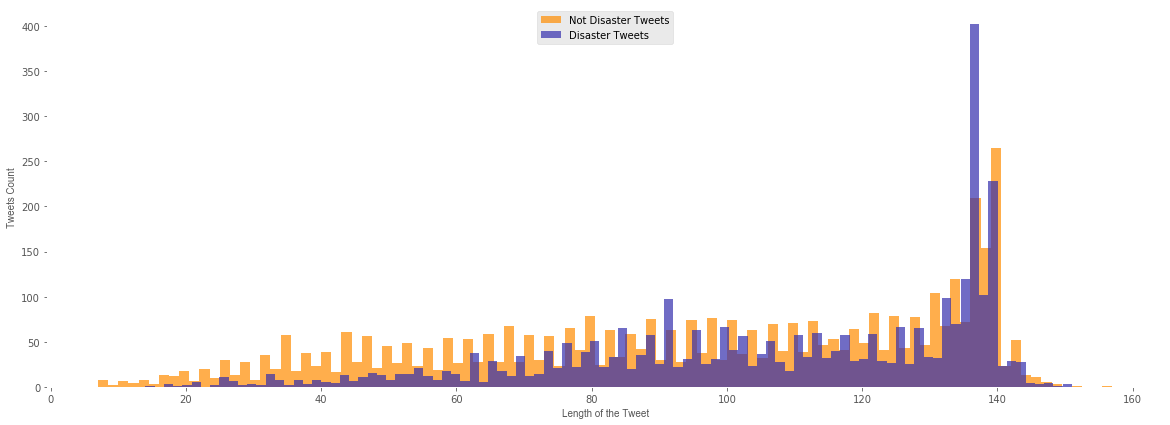

In [4]:
analyze["length_tweet"] = analyze["text"].apply(len)

plt.figure(figsize=(20, 7))

ax = plt.axes()
ax.set_facecolor("white")

plt.hist(analyze[analyze['target'] == 0]['length_tweet'], alpha = 0.7, label='Not Disaster Tweets',bins=100, color = "#FF8C00")
plt.hist(analyze[analyze['target'] == 1]['length_tweet'], alpha = 0.7, label='Disaster Tweets', bins=100, color = "#342EAD")

plt.xlabel('Length of the Tweet', **font)
plt.ylabel('Tweets Count', **font)
plt.legend(loc='upper center')
plt.show();

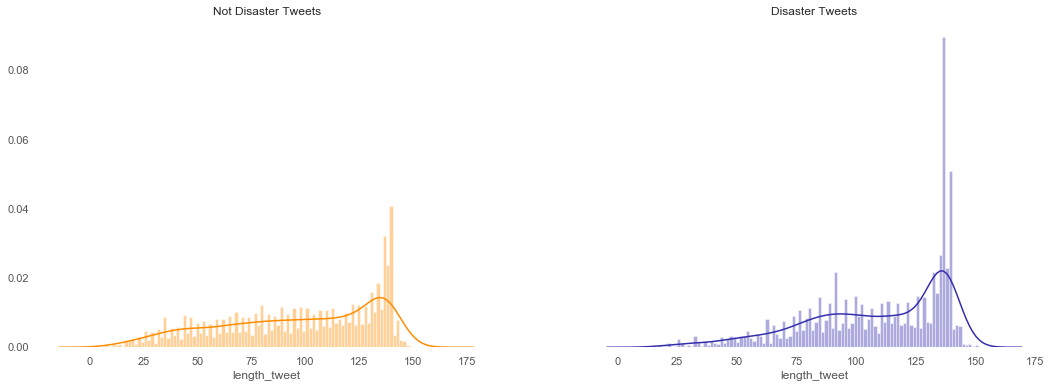

In [220]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.set(rc={'figure.figsize':(20,7)})
ax1.set_facecolor("white")
ax2.set_facecolor("white")
sns.distplot(analyze[analyze['target'] == 1]['length_tweet'], label='Disaster Tweets', bins=100, color = "#342EAD", ax=ax2).set(title = 'Disaster Tweets')
sns.distplot(analyze[analyze['target'] == 0]['length_tweet'], label='Disaster Tweets', bins=100, color = "#FF8C00", ax=ax1).set(title = 'Not Disaster Tweets');

**Observation:**

- We can see that the disaster tweets seem to be somewhat lengthier, with a concentration of Tweets around 130 to 140 characters. Note that originally Twitter allowed Tweet length to 140 characters and this later grew to 280 characters. But as cann be seen with this sample of Tweets, most of them are still below that 140 historic limit;
- Another interesting observation is that we have some repeated texts. Those are most probably retweets. We will thus need to analyze those retweets to see if they will affect our model later on or not.

#### 2.1.2 The distribution of the number of words 

Now how does the distribution of the number of words look like?

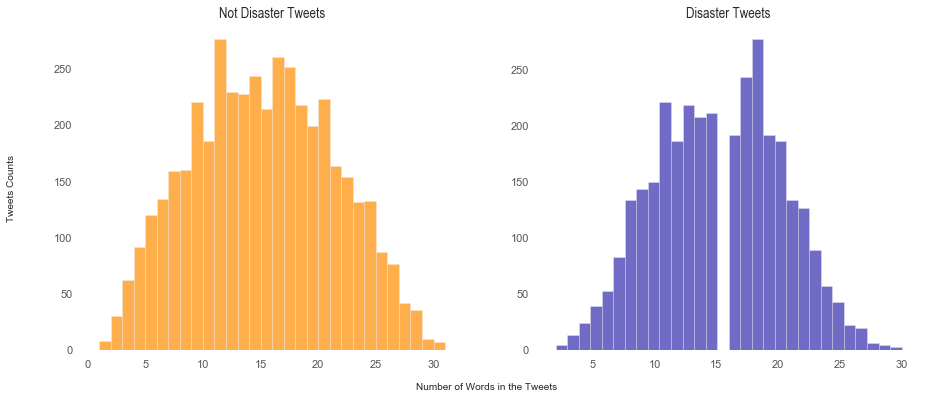

In [219]:
analyze['word_count'] = analyze['text'].apply(lambda x: len(str(x).split()))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))

ax1.hist(analyze[analyze['target'] == 0]['word_count'], color = "#FF8C00", alpha = 0.7, bins= 30)
ax1.set_title('Not Disaster Tweets', **font)
ax1.set_facecolor("white")

ax2.hist(analyze[analyze['target'] == 1]['word_count'], color = "#342EAD", alpha = 0.7, bins= 30)
ax2.set_title('Disaster Tweets', **font)
ax2.set_facecolor("white")

fig.text(0.5, 0.04, 'Number of Words in the Tweets', ha='center', va='center')
fig.text(0.06, 0.5, 'Tweets Counts', ha='center', va='center', rotation='vertical')

plt.show()

**Observation:**

- We can see that the distribution of the number of words follows a somewhat normal distribution. With most of the tweets having between 10 and 20 words.

#### 2.1.3 Looking at the Stop Words
Now that we have a general idea about the length of the content in the Tweets, we could look at the main stop words we have in those Tweets.

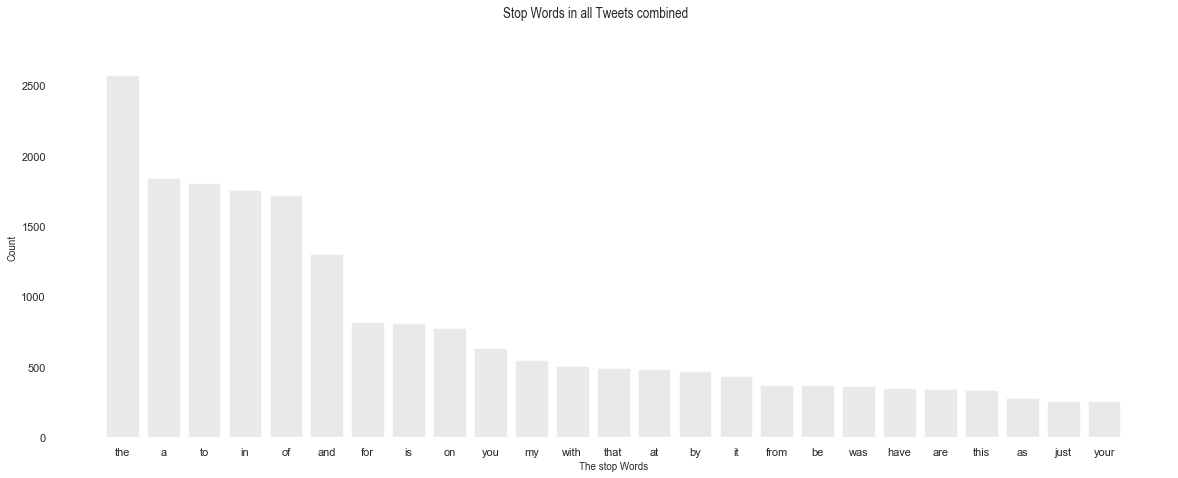

In [221]:
analyze['target2'] = 0
def creating_corpus(target):
    corpus=[]
    for x in analyze[analyze['target2']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=creating_corpus(0)
values=defaultdict(int)
for word in corpus:
    if word in stop:
        values[word]+=1
top_25=sorted(values.items(), key=lambda x:x[1],reverse=True)[:25]

a,b=zip(*top_25)
ax = plt.axes()
ax.set_facecolor("white")
plt.suptitle('Stop Words in all Tweets combined', **font)
plt.bar(a,b, alpha = 0.6, color = "#dbdbdb")
plt.xlabel('The stop Words', **font)
plt.ylabel('Count', **font);

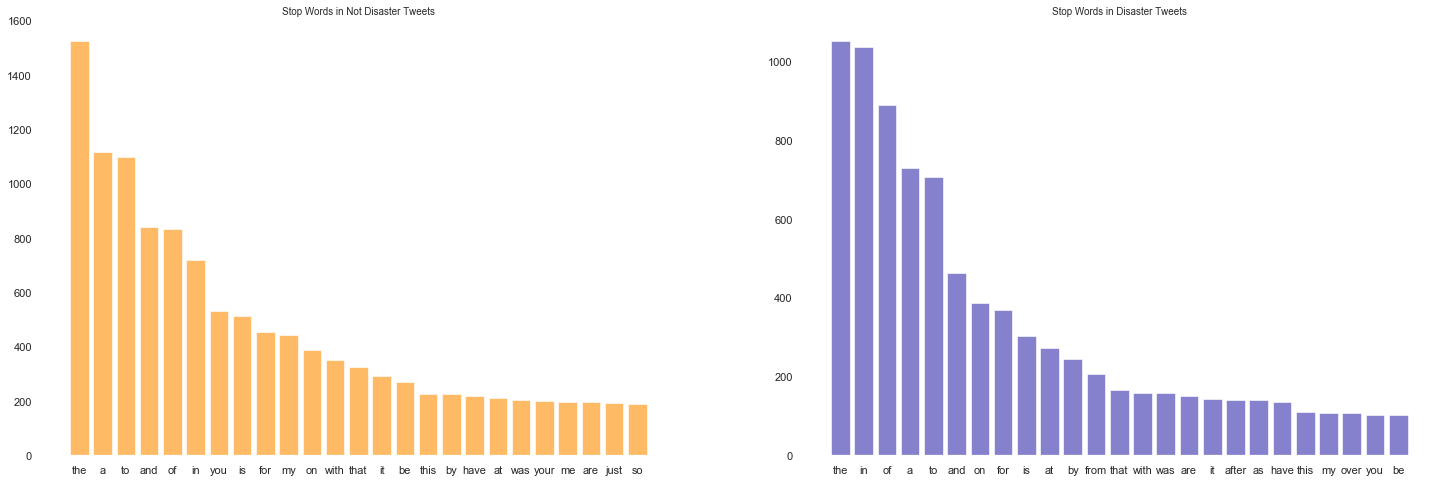

In [215]:
def creating_corpus2(target):
    corpus=[]
    for x in analyze[analyze['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=creating_corpus2(0)
values=defaultdict(int)
for word in corpus:
    if word in stop:
        values[word]+=1
top_25_0=sorted(values.items(), key=lambda x:x[1],reverse=True)[:25]

corpus2=creating_corpus2(1)
values2=defaultdict(int)
for word in corpus2:
    if word in stop:
        values2[word]+=1
top_25_1=sorted(values2.items(), key=lambda x:x[1],reverse=True)[:25]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25,8))
a,b=zip(*top_25_0)
ax1.bar(a,b, alpha = 0.6, color = "#FF8C00")
ax1.set_title('Stop Words in Not Disaster Tweets', **font)
ax1.set_facecolor("white")
c,d=zip(*top_25_1)
ax2.bar(c,d, alpha = 0.6, color = "#342EAD")
ax2.set_title('Stop Words in Disaster Tweets', **font)
ax2.set_facecolor("white")

**Observations:**

- As expected, the most common stopwords are the words "the", "a", "to", etcs. But maybe an interesting is that the word "in" is almost as frequent as "the" in the disaster Tweets;

- We will have to make a decision on whether to keep those stop words in our model or not. We will thus have to test what will be the effect of removing them later on.

#### 2.1.4 Looking at the most repeated words
With a good idea of the distribution of the stop words, we could take a look at the most repeated words other than the stop words to try to find some patterns or insights:

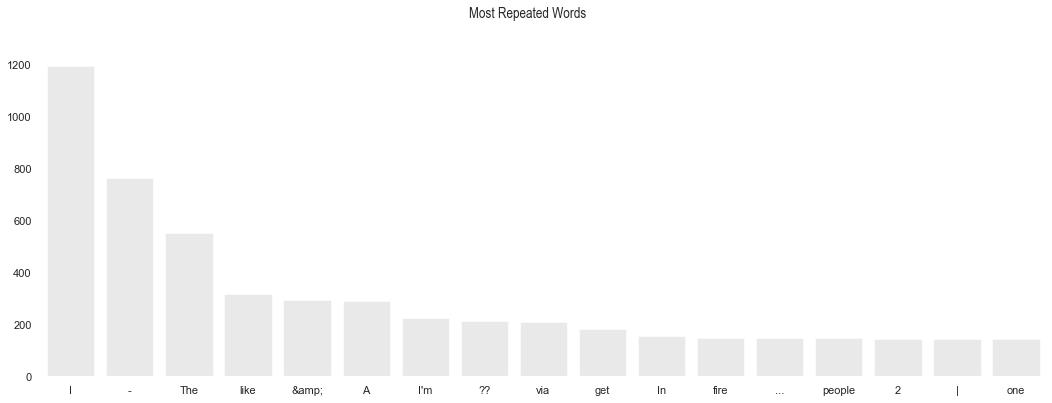

In [249]:
plt.figure(figsize=(18,6))

counting=Counter(corpus)
repeat=counting.most_common()
a=[]
b=[]
for word,count in repeat[:70]:
    if (word not in stop) :
        a.append(word)
        b.append(count)

ax = plt.axes()
ax.set_facecolor("white")
plt.suptitle('Most Repeated Words', **font)
sns.barplot(a,b, color="#dbdbdb", alpha =0.6);

**Observation:**

- We can directly see that we have some stop words that were not counted above due to their first capital letter;
- The other insight is that the words "I" (and its variation "I'm") is the most repeated word, with also the word "like" that should be kept an eye on;
- We also start noticing disaster-related words like "fire";
- There will be some cleaning required for the data, defining how to deal with the punctuation for instance.

With this good general overview on the content of the Tweets, we could now take a look at the other columns in the data and see whether they could be useful or not for our analysis.

### 2.2 The Location of Tweets
Can the location from where the Tweets were sent tell us something informative for our analysis?

In [274]:
print("The number of unique values for the location is: " + str(len(analyze['location'].unique())))
print("The correlation between the target and location is: " + str(cramers_v(analyze["target"], analyze["location"])))
percentage_loc=round(analyze['location'].isnull().sum()/len(analyze)*100,2)
print("The percentage of missing values in the location column is: " + str(percentage_loc) + "%")

The number of unique values for the location is: 3342
The correlation between the target and location is: 0.19029390748256667
The percentage of missing values in the location column is: 33.27%


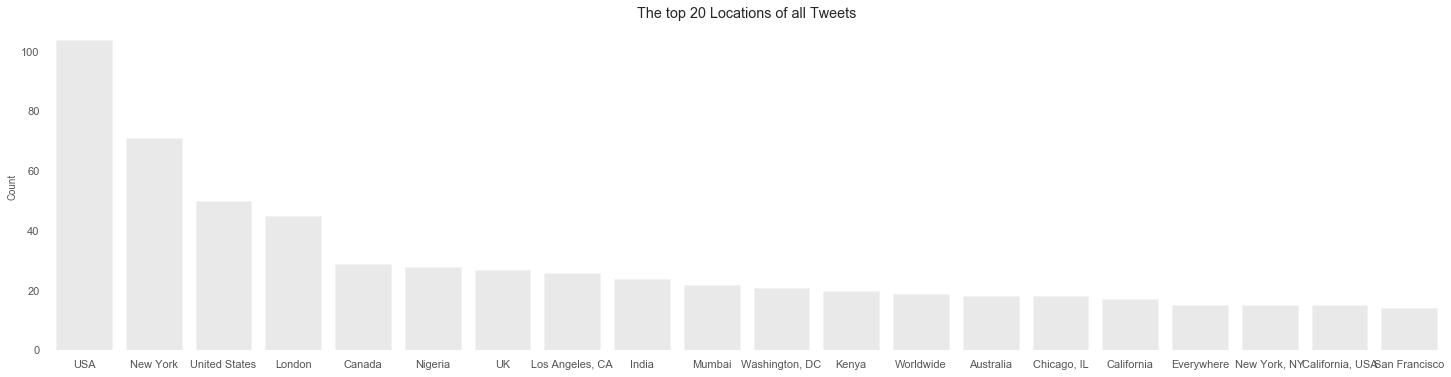

In [273]:
loca = analyze["location"].value_counts()
plt.figure(figsize=(25,6))
ax = plt.axes()
ax.set_facecolor("white")
sns.barplot(x=loca[0:20].index, y=loca[0:20], color="#dbdbdb", alpha =0.6).set(title = 'The top 20 Locations of all Tweets')
plt.ylabel('Count', **font);

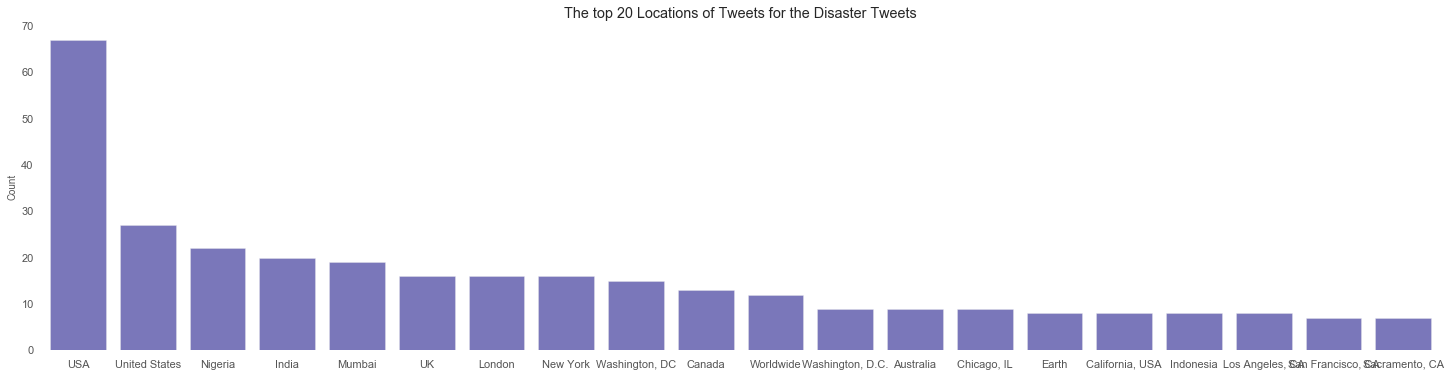

In [272]:
analyze2 = analyze.copy()
analyze2 =analyze2[analyze2['target']==1]
loca = analyze2["location"].value_counts()
plt.figure(figsize=(25,6))
ax = plt.axes()
ax.set_facecolor("white")
sns.barplot(x=loca[0:20].index, y=loca[0:20], color="#342EAD", alpha =0.7).set(title = 'The top 20 Locations of Tweets for the Disaster Tweets')
plt.ylabel('Count', **font);

**Observations:**

- We see that out of the 20 most repeated locations, the United States have 10 locations referencing to it or its cities;
- There are some irrelevant locations such as "Everywhere";
- When looking at the distribution of the locations for the tweets that do refer to disasters, we see some interesting locations increase in the ranking such as India/Mumbai, Nigeria, and UK/London;
- Another important consideration is that around one third of the location data is missing. This maybe could push us to drop the column later on if it is not very informative. Or another idea could be to process the column into continents or maybe regions.

### 2.3 The Keywords column 

Finally, we can take a look at the keyword column to see how informative it would be for our model.

In [276]:
print("The number of unique values for the keyword column is: " + str(len(analyze['keyword'].unique())))
print("The correlation between target and keyword is: " + str(cramers_v(analyze["target"], analyze["keyword"])))
percentage_kw=round(analyze['keyword'].isnull().sum()/len(analyze)*100,2)
print("The percentage of missing values in the keyword column is: " + str(percentage_kw) + "%")

The number of unique values for the keyword column is: 222
The correlation between target and keyword is: 0.5208786722791171
The percentage of missing values in the keyword column is: 0.8%


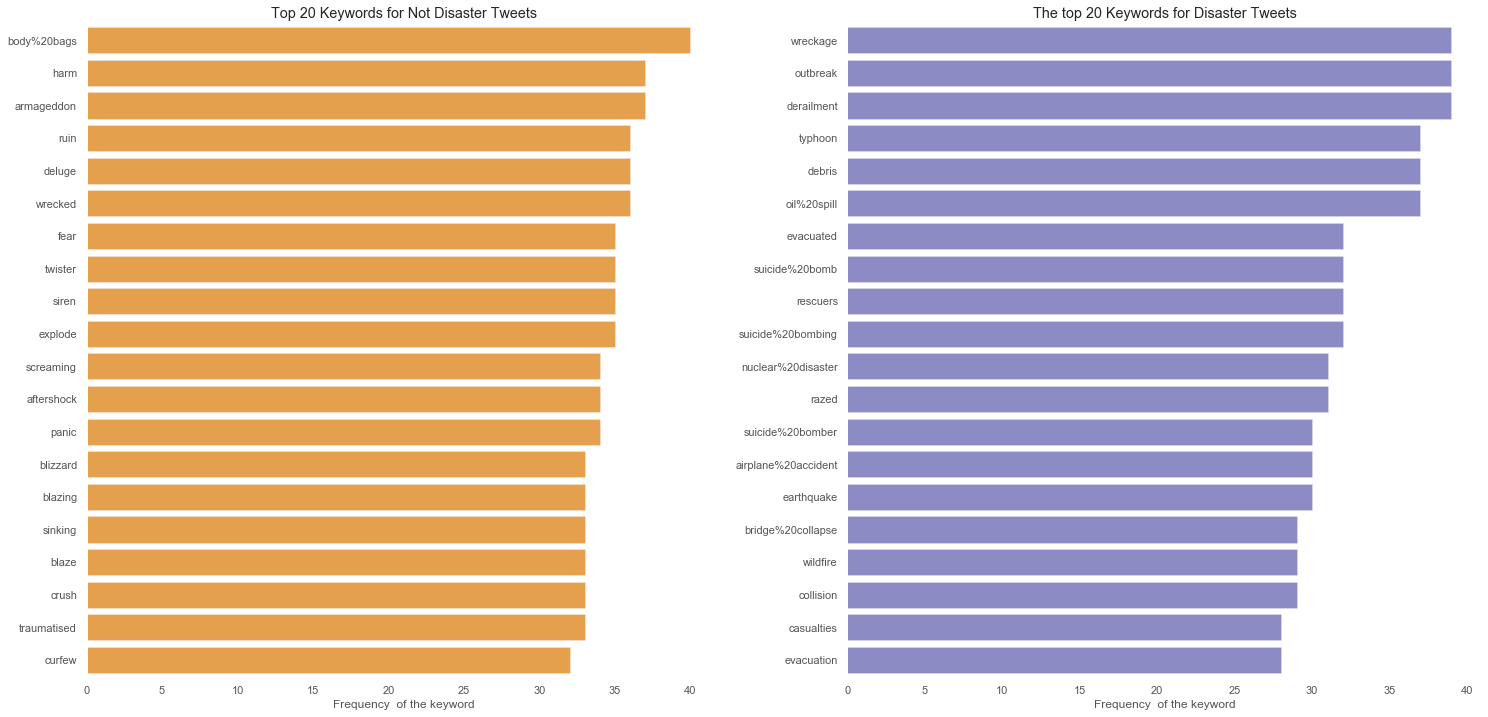

In [288]:
dis_kw = analyze.loc[analyze["target"] == 1]["keyword"].value_counts()
ndis_key = analyze.loc[analyze["target"] == 0]["keyword"].value_counts()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(25,12))
sns.barplot(y=dis_kw[0:20].index, x=dis_kw[0:20], ax=ax2, color="#342EAD", alpha=0.6)
sns.barplot(y=ndis_key[0:20].index, x=ndis_key[0:20], ax=ax1, color="#FF8C00", alpha=0.8)

ax2.set_title("The top 20 Keywords for Disaster Tweets")
ax2.set_xlabel("Frequency  of the keyword")
ax2.set_facecolor("white")

ax1.set_title("Top 20 Keywords for Not Disaster Tweets")
ax1.set_xlabel("Frequency  of the keyword")
ax1.set_facecolor("white")
plt.show()

**Observations:**

- We can see that the keyword column will be significant for our model when it comes to determining the target variable. Indeed, we have good correlation with the target variable (52%);
- Looking at the most frequent keywords for the Disaster tweets, we see that they do make sense and all relate to disasters. However, we also see that some disasters-related words are also present in the top 20 of the non-disaster Tweets. For instance ruin, deluge, blizzard, etc. Thus this will need to be looked into.

## 3. Building Baseline Models
We first start by building a baseline model from which we will develop the remaining of the notebook. We try first several classifiers and then will try to apply some processing methods learned in class to try achieving a better result.

###  3.1 RidgeClassifier Following Kaggle Tutorial

**Building vectors**
The theory behind this model is simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but good starting point).

We use scikit-learn's CountVectorizer to count the words in each tweet and turn them into data our machine learning model can process.

In [28]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train["text"])
test_vectors = count_vectorizer.transform(test["text"])
clf = linear_model.RidgeClassifier()

scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.59421842, 0.5642787 , 0.64082434])

In [301]:
clf.fit(train_vectors, train["target"])
submission["target"] = clf.predict(test_vectors)
#submission.to_csv("submission1.csv", index=False)

The score of this submission1 to the leaderboard is 0.7709.

### 3.2 Multinomial Naive Bayes Classifier

In [309]:
nb = MultinomialNB()

scores = model_selection.cross_val_score(nb, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.66763006, 0.6557971 , 0.72431507])

In [311]:
nb.fit(train_vectors, train["target"])
submission["target"] = nb.predict(test_vectors)
submission.to_csv("submission2.csv", index=False)

The score of this submission2 to the leaderboard is 0.79038.

### 3.3 Random Forrest Classifier

In [312]:
rf = RandomForestClassifier(n_estimators = 500)

scores = model_selection.cross_val_score(rf, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.54280279, 0.48401254, 0.61487965])

In [313]:
rf.fit(train_vectors, train["target"])
submission["target"] = rf.predict(test_vectors)
submission.to_csv("submission3.csv", index=False)

The score of this submission3 to the leaderboard is 0.78220.

### 3.4 Logistic Regression

In [314]:
lgr = LogisticRegression()
scores = model_selection.cross_val_score(lgr, train_vectors, train["target"], cv=3, scoring="f1")
scores

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0.6387547 , 0.61347869, 0.68350669])

In [315]:
lgr.fit(train_vectors, train["target"])
submission["target"] = lgr.predict(test_vectors)
submission.to_csv("submission4.csv", index=False)

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The score of this submission4 to the leaderboard is 0.79243.

### 3.5 SVM

In [316]:
svm = SGDClassifier(random_state=20)
scores = model_selection.cross_val_score(svm, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.57321226, 0.52510917, 0.64289204])

In [317]:
svm.fit(train_vectors, train["target"])
submission["target"] = svm.predict(test_vectors)
submission.to_csv("submission5.csv", index=False)

The score of this submission5 to the leaderboard is 0.77096.

### 3.6 Gradient Boosting Classifier

In [321]:
gb = GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.01, n_estimators = 100, max_depth = 30,random_state=20)
scores = model_selection.cross_val_score(gb, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.50880389, 0.43712575, 0.55834242])

In [322]:
gb.fit(train_vectors, train["target"])
submission["target"] = gb.predict(test_vectors)
submission.to_csv("submission6.csv", index=False)

The score of this submission6 to the leaderboard is 0.75766.

### 3.7 KNN

In [326]:
knn = KNeighborsClassifier()
scores = model_selection.cross_val_score(knn, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.19700552, 0.10376569, 0.20187793])

In [327]:
knn.fit(train_vectors, train["target"])
submission["target"] = knn.predict(test_vectors)
#submission.to_csv("submission7.csv", index=False)

The scores seemed pretty low compared to the other classifier so it was not submitted to Kaggle.

### 3.8 XGBoost Classifier

In [329]:
xgb = XGBClassifier(max_depth=6,learning_rate=0.3,n_estimators=1500,objective='binary:logistic',random_state=123,n_jobs=4)
scores = model_selection.cross_val_score(xgb, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.59390582, 0.56096337, 0.63518887])

In [331]:
xgb.fit(train_vectors, train["target"])
submission["target"] = xgb.predict(test_vectors)
submission.to_csv("submission8.csv", index=False)

The score of this submission8 to the leaderboard is 0.79038.

## 4. Data Cleaning 

Before doing some proper preprocessing of the data, because we are dealing with Tweets, it would be preferable to clean the text first. Indeed, Tweets contain a lot of anomalies that could make the performance of the model worst. We thus first start by removing some special characters, punctuations, URLs, and HTML tags.

For creating the functions we used next, we were inspired by the codes of: [Ali Tavakoli](https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python/49146722#49146722),
[Shahules786](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove), [Parul Pandey](https://www.kaggle.com/parulpandey/getting-started-with-nlp-feature-vectors) and [Gunes Evitan](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#4.-Embeddings-and-Text-Cleaning). We tried to combine their approached, adding our personnal judgement on what 

In [78]:
# An adapted veersion of the function that first make the text lowercase, remove the text in square brackets,
# remove URLS, remove some special characters, words containing numbers and remove also HTML Tags

def cleaning(data):
    data = data.lower() # we first make the data lowercase, to apply a good cleaning to all
    data = re.sub(r'https?:\/\/t.co\/[A-Za-z0-9]+', '', data) # we remove the URLs in the text
    data = re.sub("\\W"," ",data) # we remove special chars
    data = re.sub('<.*?>+', '', data) # we remove the HTML tags
    data = re.sub('\[.*?\]', '', data) # we remove the punctuation
    data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
    data = re.sub('\n', '', data)
    data = re.sub('\w*\d\w*', '', data)
    data = re.sub(r"\x89Û_", "", data) # we are using here other manually written rules after we noticed that some 
    data = re.sub(r"\x89ÛÒ", "", data)    # other characters were still present
    data = re.sub(r"\x89ÛÓ", "", data)
    data = re.sub(r"\x89ÛÏ", "", data)
    data = re.sub(r"let\x89Ûªs", "let's", data)
    data = re.sub(r"\x89Û÷", "", data)
    data = re.sub(r"\x89Ûª", "", data)
    data = re.sub(r"\x89Û\x9d", "", data)
    data = re.sub(r"å_", "", data)
    data = re.sub(r"\x89Û¢", "", data)
    data = re.sub(r"\x89Û¢åÊ", "", data)
    data = re.sub(r"åÊ", "", data)
    data = re.sub(r"åÈ", "", data)   
    data = re.sub(r"Ì©", "e", data)
    data = re.sub(r"å¨", "", data)
    data = re.sub(r"SuruÌ¤", "Suruc", data)
    data = re.sub(r"åÇ", "", data)
    data = re.sub(r"åÀ", "", data)
    return data

# will maybe use this function later:
def no_emojis(data):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # These represent the emoticons
                           u"\U0001F300-\U0001F5FF"  # These represent the symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # These represent the transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # These represent the flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emojis.sub(r'', data)

In [79]:
trainB = train.copy()
testB = test.copy()

trainB['text'] = trainB['text'].apply(lambda x : cleaning(x))
testB['text'] = testB['text'].apply(lambda x : cleaning(x))

In [500]:
## Testing model after Cleaning:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(trainB["text"])
test_vectors = count_vectorizer.transform(testB["text"])

lgr = LogisticRegression()
scores = model_selection.cross_val_score(lgr, train_vectors, trainB["target"], cv=5, scoring="f1")
scores

array([0.63049579, 0.55685619, 0.61551155, 0.5793722 , 0.71395168])

In [81]:
lgr.fit(train_vectors, trainB["target"])
submission["target"] = lgr.predict(test_vectors)
submission.to_csv("submission10.csv", index=False)

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The resulting score is slightly better than previously with a score on the Leaderboard of 0.79550.

## 5. Approach I: Basic Processing Methods

### 5.1 Removing  stopwords
As we saw in the EDA, we have an important presence of stopwords. Because they are very common, we believe thay are of little value and thus removing them could improve the model. Here, we will use the stopwords provided by NLTK through the parameter stop_word.

In [502]:
stopwords = stopwords.words('english')

### 5.2 N-Grams parameter

The CountVectorizer also allows the inclusion of N-grams into the analysis. It specifies the upper limit as well as the lower limit for the range of words to be extracted from the Tweets. Here we use ngram_range = (1,2) meaning Unigrams and Bigrams.

In [103]:
count_vectorizer = feature_extraction.text.CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = stopwords)

train_vectors = count_vectorizer.fit_transform(trainB["text"])
test_vectors = count_vectorizer.transform(testB["text"])

lgr = LogisticRegression()
scores = model_selection.cross_val_score(lgr, train_vectors, trainB["target"], cv=5, scoring="f1")
scores

array([0.5928934 , 0.49129239, 0.56864482, 0.49345418, 0.6986532 ])

In [104]:
lgr.fit(train_vectors, trainB["target"])
submission["target"] = lgr.predict(test_vectors)
submission.to_csv("submission13.csv", index=False)

This one scored the highest so far with 0.81186.

### 5.3 Mislabeled entries
As noticed in the EDA, we saw that some Tweets were duplicated. We here check that those Tweets are consistent with their labels in the target column. We noticed they were not and thus try to modify those labels to have a unified classification for those duplicate Tweets.

In [1054]:
trainC = trainB.copy()
testC = testB.copy()

pd.set_option('display.max_rows', None)
mislabeled = trainC.groupby(['text']).nunique().sort_values(by='target', ascending=False)
mislabeled = mislabeled[mislabeled['target'] > 1]
mislabeled.head(10)

,id,keyword,location,text,target
text,,,,,
the dress memes have officially exploded on the internet,3,1,1,1,2
caution breathing may be hazardous to your health,2,1,0,1,2
truth news bbc cnn islam truth god isis terrorism quran lies,7,1,0,1,2
world fedex no longer to transport bioterror germs in wake of anthrax lab mishaps,2,1,1,1,2
why are you deluged with low self image take the quiz,2,1,2,1,2
cindy noonan cindynoonan heartbreak in baltimore rioting yahistorical undergroundrailraod,2,1,2,1,2
to fight bioterrorism sir,4,1,0,1,2
foodscare nestleindia slips into loss after magginoodle ban unsafe and hazardous for humanconsumption,3,1,2,1,2
like for the music video i want some real action shit like burning buildings and police chases not some weak ben winston shit,2,2,1,1,2


Based on the table above, each row was run manually with the codes below and relabelled as either 1 or 0 based on the percentage of 1s for each sentence. For those with 50% or higher 1s, they weere relabeled as 1 (this was done manually because figuring out the code was not an easy task).

In [785]:
# 6 out 46 mislabeled as 1
trainC.loc[trainC['text'].str.contains("reddit") & trainC['text'].str.contains('quarantine') & 
           trainC['text'].str.contains('content'), 'target'] = 0 
# 5 out 17 mislabeled as 1
trainC.loc[trainC['text'].str.contains("funtenna") & trainC['text'].str.contains('funtenna') & 
           trainC['text'].str.contains('waves'), 'target'] = 0
# 1 out of 3 mislabeled as 0
trainC.loc[trainC['text'].str.contains("cleared") & trainC['text'].str.contains('georgia') & 
           trainC['text'].str.contains('ave'), 'target'] = 1 
# 1 out of 9 mislabeled as 1
trainC.loc[trainC['text'].str.contains("black") & trainC['text'].str.contains('eye') & 
           trainC['text'].str.contains('destroyed'), 'target'] = 0
# 1 out of 8 mislabeled as 0 
trainC.loc[trainC['text'].str.contains("hot") & trainC['text'].str.contains('specially') & 
           trainC['text'].str.contains('prebreak'), 'target'] = 1
# 1 out of 9 mislabeled as 1
trainC.loc[trainC['text'].str.contains("spot") & trainC['text'].str.contains('flood') & 
           trainC['text'].str.contains('combo'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("accionempresa") & trainC['text'].str.contains('sparked') & 
           trainC['text'].str.contains('interest'), 'target'] =1 
# 1 out of 3 mislabeled as 1 
trainC.loc[trainC['text'].str.contains("whipped") & trainC['text'].str.contains('petition') & 
           trainC['text'].str.contains('owner'), 'target'] = 0
# 1 out of 6 mislabeled as 1
trainC.loc[trainC['text'].str.contains("detonate") & trainC['text'].str.contains('feat') & 
           trainC['text'].str.contains('brown'), 'target'] = 0
# 1 out of 3 mislabeled as 1
trainC.loc[trainC['text'].str.contains("allah") & trainC['text'].str.contains('description') & 
           trainC['text'].str.contains('people'), 'target']  = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("governor") & trainC['text'].str.contains('weighs') & 
           trainC['text'].str.contains('parole'), 'target'] = 1
# 1 out of 3 mislabeled as 1 
trainC.loc[trainC['text'].str.contains("angry") & trainC['text'].str.contains('woman') & 
           trainC['text'].str.contains('internally'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("liked") & trainC['text'].str.contains('youtube') & 
           trainC['text'].str.contains('itsjustinstuart'), 'target'] = 1
# 3 out of 8 mislabeled as 1
trainC.loc[trainC['text'].str.contains("park") & trainC['text'].str.contains('services') & 
           trainC['text'].str.contains('annihilation'), 'target'] = 0
# 6 out of 16 mislabeled as 1
trainC.loc[trainC['text'].str.contains("china") & trainC['text'].str.contains('stock') & 
           trainC['text'].str.contains('gems'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("mmmmmm") & trainC['text'].str.contains('burning') & 
           trainC['text'].str.contains('ooh'), 'target'] =1
# 4 out of 13 mislabeled as 1
trainC.loc[trainC['text'].str.contains("pandemonium") & trainC['text'].str.contains('in') & 
           trainC['text'].str.contains('aba'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("star") & trainC['text'].str.contains('collection') & 
           trainC['text'].str.contains('hasbro'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("choking") & trainC['text'].str.contains('hazard') & 
           trainC['text'].str.contains('prompts'), 'target'] = 1
# 1 out of 3 mislabeled as 1
trainC.loc[trainC['text'].str.contains("detonation") & trainC['text'].str.contains('mountaineering') & 
           trainC['text'].str.contains('leisure'), 'target'] = 0
# 1 out of 2 mislabeled as 0 
trainC.loc[trainC['text'].str.contains("kosciusko") & trainC['text'].str.contains('pedestrian') & 
           trainC['text'].str.contains('fatality'), 'target'] = 1
# 1 out of 8 mislabeled as 1
trainC.loc[trainC['text'].str.contains("one") & trainC['text'].str.contains('direction') & 
           trainC['text'].str.contains('pick'), 'target'] = 0
# 3 out of 6 mislabeled as 0
trainC.loc[trainC['text'].str.contains("look") & trainC['text'].str.contains('actions') & 
           trainC['text'].str.contains('ferguson'), 'target'] = 1
# 1 out of 3 mislabeled as 0
trainC.loc[trainC['text'].str.contains("sassy") & trainC['text'].str.contains('smoky') & 
           trainC['text'].str.contains('ibooklove'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("do") & trainC['text'].str.contains('sinking') & 
           trainC['text'].str.contains('image'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("world") & trainC['text'].str.contains('autobiography') & 
           trainC['text'].str.contains('general'), 'target'] = 1
# 1 out of 12 mislabeled as 1
trainC.loc[trainC['text'].str.contains("new") & trainC['text'].str.contains('ladies') & 
           trainC['text'].str.contains('shoulder'), 'target'] = 0
# 2 out of 6 mislabeled as 1
trainC.loc[trainC['text'].str.contains("engulfed") & trainC['text'].str.contains('came') & 
           trainC['text'].str.contains('prophetmuhammad'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("australia") & trainC['text'].str.contains('bridge') & 
           trainC['text'].str.contains('history'), 'target'] = 1
# 5 out of 18 mislabeled as 0
trainC.loc[trainC['text'].str.contains("fedex") & trainC['text'].str.contains('bioterror') & 
           trainC['text'].str.contains('mishaps'), 'target'] = 1
# 1 out of 4 mislabeled as 1
trainC.loc[trainC['text'].str.contains("drunk") & trainC['text'].str.contains('meals') & 
           trainC['text'].str.contains('obliterated'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("world") & trainC['text'].str.contains('annihilation') & 
           trainC['text'].str.contains('attack'), 'target'] = 1
# 1 out of 3 mislabeled as 1
trainC.loc[trainC['text'].str.contains("watch") & trainC['text'].str.contains('sarah') & 
           trainC['text'].str.contains('palin'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("here") & trainC['text'].str.contains('pakistan') & 
           trainC['text'].str.contains('mohammed'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("islam") & trainC['text'].str.contains('hellfire') & 
           trainC['text'].str.contains('mention'), 'target'] = 1
# 1 out of 5 mislabeled as 0
trainC.loc[trainC['text'].str.contains("potus") & trainC['text'].str.contains('strategicpatience') & 
           trainC['text'].str.contains('idp'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("rt") & trainC['text'].str.contains('notexplained') & 
           trainC['text'].str.contains('hijacker'), 'target'] = 1
# 2 out of 7 mislabeled as 1
trainC.loc[trainC['text'].str.contains("remove") & trainC['text'].str.contains('linkury') & 
           trainC['text'].str.contains('hijacker'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("islam") & trainC['text'].str.contains('humans') & 
           trainC['text'].str.contains('terrorism'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("survival") & trainC['text'].str.contains('emergency') & 
           trainC['text'].str.contains('torch'), 'target'] =1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("fire") & trainC['text'].str.contains('hazard') & 
           trainC['text'].str.contains('cbplawyers'), 'target'] = 1
# 1 out of 5 mislabeled as 1
trainC.loc[trainC['text'].str.contains("hellfire") & trainC['text'].str.contains('desires') & 
           trainC['text'].str.contains('afterlife'), 'target'] = 0
# 1 out of 5 mislabeled as 1
trainC.loc[trainC['text'].str.contains("enugu") & trainC['text'].str.contains('government') & 
           trainC['text'].str.contains('structures'), 'target'] = 0
# 2 out of 6 mislabeled as 1
trainC.loc[trainC['text'].str.contains("prophet") & trainC['text'].str.contains('hellfire') & 
           trainC['text'].str.contains('charity'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("wowo") & trainC['text'].str.contains('repatriated') & 
           trainC['text'].str.contains('cameroon'), 'target'] = 1
# 1 out of 4 mislabeled as 1
trainC.loc[trainC['text'].str.contains("pbban") & trainC['text'].str.contains('armageddon') & 
           trainC['text'].str.contains('reason'), 'target'] = 0
# 1 out of 4 mislabeled as 1
trainC.loc[trainC['text'].str.contains("cree") & trainC['text'].str.contains('offroad') & 
           trainC['text'].str.contains('beam'), 'target'] = 0
# 3 out of 7 mislabeled as 1
trainC.loc[trainC['text'].str.contains("horrible") & trainC['text'].str.contains('sinking') & 
           trainC['text'].str.contains('realise'), 'target'] = 0
# 4 out of 16 mislabeled as 1
trainC.loc[trainC['text'].str.contains("hollywood") & trainC['text'].str.contains('movie') & 
           trainC['text'].str.contains('chile'), 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("pledge") & trainC['text'].str.contains('burning') & 
           trainC['text'].str.contains('buildings'), 'target'] = 1
# 5 out of 20 mislabeled as 1
trainC.loc[trainC['text'].str.contains("ignition") & trainC['text'].str.contains('detonation') & 
           trainC['text'].str.contains('sensor'), 'target'] = 0
# 1 out of 3 mislabeled as 1
trainC.loc[trainC['text'].str.contains("bringing") & trainC['text'].str.contains('farrakhan ') & 
           trainC['text'].str.contains('god'), 'target'] = 0
# 1 out of 2 is mislabeled as 0
trainC.loc[trainC['text'].str.contains("twia") & trainC['text'].str.contains('windstorm') & 
           trainC['text'].str.contains('directors'), 'target'] = 1
# 3 out of 10 mislabeled as 0
trainC.loc[trainC['text'].str.contains("bayelsa") & trainC['text'].str.contains('jonathan') & 
           trainC['text'].str.contains('plans'), 'target'] = 1
# 1 out of 3 mislabeled as 1
trainC.loc[trainC['text'] == 'the dress memes have officially exploded on the internet ', 'target'] = 0
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("caution") & trainC['text'].str.contains('breathing'), 'target'] = 1
# 3 out of 7 mislabeled as 0
trainC.loc[trainC['text'].str.contains("truth") & trainC['text'].str.contains('islam'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("deluged") & trainC['text'].str.contains('quiz') & 
           trainC['text'].str.contains('why'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("cindy") & trainC['text'].str.contains('noonan') & 
           trainC['text'].str.contains('heartbreak') , 'target'] = 1
# 2 out of 4 mislabeled as 0
trainC.loc[trainC['text'].str.contains("fight") & trainC['text'].str.contains('bioterrorism') & 
           trainC['text'].str.contains('sir'), 'target'] = 1
# 1 out of 3 mislabeled as 0
trainC.loc[trainC['text'].str.contains("foodscare") & trainC['text'].str.contains('nestleindia') & 
           trainC['text'].str.contains('magginoodle'), 'target'] = 1
# 1 out of 2 mislabeled as 0
trainC.loc[trainC['text'].str.contains("burning") & trainC['text'].str.contains('buildings') & 
           trainC['text'].str.contains('winston'), 'target'] = 1

In [ ]:
count_vectorizer = feature_extraction.text.CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = stopwords)

train_vectors = count_vectorizer.fit_transform(trainC["text"])
test_vectors = count_vectorizer.transform(testC["text"])

lgr = LogisticRegression()
scores = model_selection.cross_val_score(lgr, train_vectors, trainC["target"], cv=5, scoring="f1")
scores

In [463]:
lgr.fit(train_vectors, trainC["target"])
submission["target"] = lgr.predict(test_vectors)
submission.to_csv("submission14.csv", index=False)

This did not work, it did not imporve the score. Score was 0.80470.

### 5.4 Using the Keyword column to improve the performance
So far we had only been using the text to classify our Tweets. What if we tweaked the predictions a little bit by using the Keyword column provided in the dataset?
We do so by looking at the probability that a keyword point to a disaster-related Tweet. We then set a treshold of 90% for this probability and look at our best predictions. If the ones with this probability of 90% or higher are classified as not real disaster Tweets, we change those predictions (we were inspired by  [Mohsen Yazdinejad](https://www.kaggle.com/bandits/using-keywords-for-prediction-improvement).

In [508]:
trainE = trainB.copy()
trainE = trainE.fillna('Other')
calculation = trainE.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Probability of Real Disaster'})
calculation.sort_values('Probability of Real Disaster', ascending=False).head(15)

,Count,Probability of Real Disaster
keyword,,
wreckage,39,1.000000
debris,37,1.000000
derailment,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.931034


We see that we have 12 keywords above this 90% treshold and that appear many times (around 30 times each). Those are the ones we deem important and thus we will use them to modify our initial submission in 5.2.

In [512]:
keyword_treshold = list(calculation[(calculation['Count']>10) & (calculation['Probability of Real Disaster']>=0.9)].index)

In [513]:
submission_modified = pd.read_csv('submission13.csv')
ids = testE['id'][testE.keyword.isin(keyword_treshold)].values
submission_modified['target'][submission_modified['id'].isin(ids)] = 1
submission_modified.to_csv("submission17.csv", index=False)

The performance did improve to 0.81288 and is the best one so far.
We believe that manually setting this treshold to 0.9 is maybe not the best way to do it. So instead getting the predictions from the model and changing the output, we could get the probabilities. And then we would train a new model with 2 input variables, one the probability from the initial model and second being the keyword. In this way the model can learn the optimum thresholds and also decide on the weights for both inputs instead of blindly overwriting the output. We will explore this in the next approaches.

### 5.5 Conclusion Approach I

Until now, our model was based on 3 pillars:

1. Cleaning step (removing URLs, HTML tags, special characters, etc)
2. Removing stopwords 
3. Using Unigram and Bigrams generators 

And the best score after the modification of the predictions with the consideration of the keywords' probability was 0.81288.

Other ideas like changing mislabeled entries after the transformations did not work but could be beneficial in the next approaches.

## 6. Approach II: Tokenization, Stemming, Lematization and  TF - IDF

So far, we have only used basic processing ideas.
In this second approach, we built on top of the fundations of Approach I to try to get better results.
This approach will include the following steps:

- Cleaning (same steps as in Approach I)
- Tokenization, Stemming, and Lematization 
- TF - IDF
- New approach to including the keywords 
- Using SVM and Logistic Regression

### 6.1 Pre-cleaning

As mentionned above, we start from the cleaned data we got after running the cleaning functions defined above. We thus make a copy of trainB and testB (the cleaned datasets).

In [921]:
trainD = trainB.copy()
testD = testB.copy()

### 6.2 Tokenization, Stemming, and Lematization
This approach contains more data normalization that the previous one. Before being able to use normalization techniques, we have to tokenize the text (split the Tweets into array of words). Then, we will be able to apply stemming (reducing the words to their root form) and lematizing (grouping together the inflected forms of a word so in order to analyse them as a single element). We also, like in the preceding approach, remove the stopwords (for this section, we were inspired by the code of [Regis](https://www.kaggle.com/rerere/disaster-tweets-svm#Text-preprocessing---Normalization)).

In [922]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
p_stemmer = PorterStemmer()
wn_lemmatizer = WordNetLemmatizer()

def normalising(text):
    elements = word_tokenize(text)     # We tokenize into array of words
    elements = [word.lower() for word in elements]
    list_words = [word for word in elements if word.isalpha()] # We remove the elements that are not alphabetic
    list_words = [word for word in list_words if not word in stop_words] # We remove the stopwords
    stemmed_words = [p_stemmer.stem(word) for word in list_words] # We reduce the words to their root
    stemmed_and_lematized = [wn_lemmatizer.lemmatize(word) for word in stemmed_words] # # We lematize the words 
    return stemmed_and_lematized

trainD["text"] = trainD.text.apply(normalising)
testD["text"] = testD.text.apply(normalising)

In [923]:
trainD.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deed, reason, earthquak, may, allah, forgiv, u]",1
1,4,NaN,NaN,"[forest, fire, near, la, rong, sask, canada]",1
2,5,NaN,NaN,"[resid, ask, shelter, place, notifi, offic, evacu, shelter, place, order, expect]",1
3,6,NaN,NaN,"[peopl, receiv, wildfir, evacu, order, california]",1
4,7,NaN,NaN,"[got, sent, photo, rubi, alaska, smoke, wildfir, pour, school]",1


### 6.3 Including the keywords into the text
For including the keywords, unlike the preceding approach, we decided to use another method. Instead of editing the predictions, we add the keywords to the beginning of the Tweets.

In [924]:
def make_list(data):
    return " ".join(data)
trainD["text"] = trainD["text"].apply(make_list) # We go from arrays back to sentences
testD["text"] = testD["text"].apply(make_list)

def normalise_keywords(word):
    return word.split('%20')

trainD["keyword"] = trainD['keyword'].fillna(" ") # We replace the missing values in the keyword column by an empty field
testD["keyword"] = testD['keyword'].fillna(" ")

trainD["keyword"] = trainD["keyword"].apply(normalise_keywords).apply(make_list) # We normalise the keywords and make them into normal sentences
testD["keyword"] = testD["keyword"].apply(normalise_keywords).apply(make_list)

trainD["text"] = trainD["keyword"] + " " + trainD["text"] # We add the keywords to the Tweets
testD["text"] = testD["keyword"] + " " + testD["text"] 
trainD.sample(5)

,id,keyword,location,text,target
641,930,blaze,NaN,blaze pool day raisinfing,0
3678,5233,fatality,Grand Rapids MI,fatality fatalityu need team need one,0
2406,3464,derailed,"Kwara, Nigeria",derailed use exactli nation assembl honestli worthless derail,0
237,337,annihilated,University of Toronto,annihilated sirbrandonknt exactli lesnar cena match summerslam last year great brock annihil guy,0
5121,7302,nuclear reactor,NaN,nuclear reactor quick fact nuclear reactor come oper u year,0


### 6.4 TF - IDF

In the previous approach, we used CountVectorizer, with which we use the counts of the words for our model. Here, with the TFIDF approach, we take the relative importance of the terms in the entire corpus. 

The 'TF' stands for the normalized Term Frequency. In other words, the scoring of the frequency of the word in the Tweet (its formula is Term Frequency = (Number of times the word appears in a Tweet)/(Number of words in the Tweet)).

And the 'IDF' stands for Inverse Document Frequency. It is the scoring of how rare the word is across the Tweet (its formula is Inverse Document Frequency = 1+log(N/n), where N is the number of Tweets and n is the number of Tweets a word has appeared in).

In [865]:
all_data = pd.concat([trainD["text"], testD["text"]]) # We put the train and test data together

tfidf = TfidfVectorizer(stop_words = 'english')
tfidf.fit(all_data)
X = tfidf.transform(trainD["text"])
X_test = tfidf.transform(testD["text"])
del all_data

train, test = train_test_split(trainD, test_size=0.2)
train_x = trainD["text"]
train_y = trainD["target"]
test_x = testD["text"]
test_y = test["target"]

X_train, X_val, y_train, y_val = train_test_split(X, trainD["target"], test_size=0.1, random_state=42)

### 6.5 Running a SVM model with GridSearch

In [856]:
parameters = { 'gamma': [0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.7, 1], 'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 3, 10],}

In [857]:
model = GridSearchCV(SVC(), parameters, cv=10, n_jobs=-1).fit(X_train, y_train)

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [858]:
y_val_pred = model.predict(X_val)
accuracy_score(y_val, y_val_pred), f1_score(y_val, y_val_pred)

(0.800524934383202, 0.7483443708609272)

In [859]:
y_test_pred = model.predict(X_test)

In [860]:
submission["target"] = y_test_pred
submission.to_csv("submission22.csv", index=False)

This submission yields a score of 0.81697 on the Leaderboard, our highest score so far. We can thus see that these further normalization techniques and the TF-IDF approach yielded a better result.

### 6.6 Running a Logistic Regression model with Hyperparameter tunning
(Here, we were inspired by [Enes Polat](https://www.kaggle.com/enespolat/grid-search-with-logistic-regression)'s approach for the GridSearch for the logistic regression)

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)
print("The tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("The accuracy :",logreg_cv.best_score_)

In [572]:
lg=LogisticRegression(C=1,penalty="l2")
lg.fit(X_train,y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [573]:
y_val_pred = lg.predict(X_val)
accuracy_score(y_val, y_val_pred), f1_score(y_val, y_val_pred)

(0.7834645669291339, 0.72636815920398)

In [575]:
y_test_pred = lg.predict(X_test)
submission["target"] = y_test_pred
submission.to_csv("submission24.csv",index=False)

Surprisingly, the Logistic Regression performs worse here with a score on the Leaderboard of 0.79550.

### 6.7 Adding the words embeddings
For a beetter understanding on how to implement embeddings, we used the explanation of [Prachi Chitnis](https://www.kaggle.com/prachichitnis/stack-tfidf-embedding-xgboost).

In [869]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
train_embeddings = embed(trainD['text'])
test_embeddings = embed(testD['text'])

X_feat=sparse.csr_matrix(train_embeddings.numpy())
X_test=sparse.csr_matrix(test_embeddings.numpy())

In [884]:
X_train, X_val, y_train, y_val = train_test_split(X_feat, trainD["target"], test_size=0.1, random_state=42)
parameters = { 'gamma': [0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.7, 1], 'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 3, 10],}
model = GridSearchCV(SVC(), parameters, cv=10, n_jobs=-1).fit(X_train, y_train)
y_val_pred = model.predict(X_val)
accuracy_score(y_val, y_val_pred), f1_score(y_val, y_val_pred)

(0.8083989501312336, 0.7718750000000001)

In [885]:
y_test_pred = model.predict(X_test)
submission["target"] = y_test_pred
submission.to_csv("submissionEmbedingsII.csv", index=False)

The submission of the Leaderboard yielded a score of 0.7950 and thus the embeddings do not add value here.

### 6.8 Trying POS Tagging 

In [610]:
trainH = trainB.copy()
testH = testB.copy()

In [624]:
def normalising2(text):
    elements = word_tokenize(text)     # We tokenize into array of words
    elements = [word.lower() for word in elements]
    list_words = [word for word in elements if word.isalpha()] # We remove the elements that are not alphabetic
    list_words = [word for word in list_words if not word in stop_words] # We remove the stopwords
    #stemmed_words = [p_stemmer.stem(word) for word in list_words] # We reduce the words to their root
    lematized_text = [wn_lemmatizer.lemmatize(word) for word in list_words] # # We lematize the words 
    return lematized_text

trainH["new_text"] = trainH.text.apply(normalising2)
testH["new_text"] = testH.text.apply(normalising2)

In [625]:
# We use the POS tagging provided by NLTK
trainH['POS'] = trainH['new_text'].apply(nltk.tag.pos_tag)
testH['POS'] = testH['new_text'].apply(nltk.tag.pos_tag)

In [616]:
trainH.head()

,id,keyword,location,text,target,new_text,POS
0,1,NaN,NaN,our deeds are the reason of this earthquake may allah forgive us all,1,"[deed, reason, earthquake, may, allah, forgive, u]","[(deed, NN), (reason, NN), (earthquake, NN), (may, MD), (allah, VB), (forgive, JJ), (u, NN)]"
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, JJ), (ronge, NN), (sask, NN), (canada, NN)]"
2,5,NaN,NaN,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,1,"[resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected]","[(resident, NN), (asked, VBD), (shelter, JJ), (place, NN), (notified, JJ), (officer, NN), (evacuation, NN), (shelter, NN), (place, NN), (order, NN), (expected, VBD)]"
3,6,NaN,NaN,people receive wildfires evacuation orders in california,1,"[people, receive, wildfire, evacuation, order, california]","[(people, NNS), (receive, VBP), (wildfire, NN), (evacuation, NN), (order, NN), (california, NN)]"
4,7,NaN,NaN,just got sent this photo from ruby alaska as smoke from wildfires pours into a school,1,"[got, sent, photo, ruby, alaska, smoke, wildfire, pours, school]","[(got, VBD), (sent, JJ), (photo, NN), (ruby, NN), (alaska, NN), (smoke, VBD), (wildfire, NN), (pours, NN), (school, NN)]"


In [627]:
# We assign the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(trainH['POS'], trainH['target'], test_size=0.20, random_state=20)

# We can create a pipeline for a Logistic Regression
lg_pipe = Pipeline([('vectorizer', CountVectorizer()), ('tfidf', TfidfTransformer()),('logreg', LogisticRegression(n_jobs=1))])
lg_pipe = lg_pipe.fit(X_train.astype(str), y_train.astype(str))
lg_pred = lg_pipe.predict(testH.POS.astype(str))
        
submission = pd.DataFrame(lg_pred, columns=['target'])
submission = pd.concat([testH.id,submission], axis=1, ignore_index=True)
submission = submission.rename(columns = {0:'id', 1: 'target'})
submission.to_csv('submission25.csv', index=False)

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### 6.9 Discussion: the better approach for considering the Keywords
In both Approach I and II, we use the keywords in different manners. 
Here, we try to use the same procedure as we did in Approach I, that of editing the predictions based on the probability of the keyword to indicate a disaster instead of adding the keyword to the text as we did.

In [569]:
calculation = trainD.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Probability of Real Disaster'})
calculation.sort_values('Probability of Real Disaster', ascending=False).head(15)
keyword_treshold = list(calculation[(calculation['Count']>10) & (calculation['Probability of Real Disaster']>=0.9)].index)
keyword_treshold

['bombing',
 'debris',
 'derailment',
 'nuclear disaster',
 'oil spill',
 'outbreak',
 'rescuers',
 'suicide bomb',
 'suicide bomber',
 'suicide bombing',
 'typhoon',
 'wreckage']

In [570]:
submission_modified = pd.read_csv('submission22.csv')
ids = testD['id'][testD.keyword.isin(keyword_list)].values
submission_modified['target'][submission_modified['id'].isin(ids)] = 1
submission_modified.to_csv("submission23.csv", index=False)

We get a lower score of 0.80163 and thus could say that adding the keywords to the text of the Tweet is a good (and maybe better) way to consider the keyword column.

## 7. Approach III: Better Preprocessing with correction of Spelling Mistakes
Pre-processing is probably one of the most important steps when dealing with Tweets. We thus here focus on doing better pre-processing by correcting the spelling mistakes.
To do this, we use the pyspellchecker library and the function developped by [Shahules786](https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove). We then re-run several of the models established above to see the effect of this step. 
Before running the spelling corrections, we clean the tweets with our created function above and here add a function to fix the contractions (those were inspired by [Gunes Evitan](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)).

### 7.1 Running the Correct Spelling Function on the data

In [ ]:
# This is the function for correcting the spelling mistakes
def correct_spellings(data):
    correct = []
    misspelled = SpellChecker().unknown(data.split())
    for word in data.split():
        if word in misspelled:
            correct.append(SpellChecker().correction(word))
        else:
            correct.append(word)
    return " ".join(correct)

# This is the function for correcting the contractions
def replace_contractions(data):
    data = re.sub(r"he's", "he is", data)
    data = re.sub(r"there's", "there is", data)
    data = re.sub(r"We're", "We are", data)
    data = re.sub(r"That's", "That is", data)
    data = re.sub(r"won't", "will not", data)
    data = re.sub(r"they're", "they are", data)
    data = re.sub(r"Can't", "Cannot", data)
    data = re.sub(r"wasn't", "was not", data)
    data = re.sub(r"don\x89Ûªt", "do not", data)
    data = re.sub(r"aren't", "are not", data)
    data = re.sub(r"isn't", "is not", data)
    data = re.sub(r"What's", "What is", data)
    data = re.sub(r"haven't", "have not", data)
    data = re.sub(r"hasn't", "has not", data)
    data = re.sub(r"There's", "There is", data)
    data = re.sub(r"He's", "He is", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"You're", "You are", data)
    data = re.sub(r"I'M", "I am", data)
    data = re.sub(r"shouldn't", "should not", data)
    data = re.sub(r"wouldn't", "would not", data)
    data = re.sub(r"i'm", "I am", data)
    data = re.sub(r"I\x89Ûªm", "I am", data)
    data = re.sub(r"I'm", "I am", data)
    data = re.sub(r"Isn't", "is not", data)
    data = re.sub(r"Here's", "Here is", data)
    data = re.sub(r"you've", "you have", data)
    data = re.sub(r"you\x89Ûªve", "you have", data)
    data = re.sub(r"we're", "we are", data)
    data = re.sub(r"what's", "what is", data)
    data = re.sub(r"couldn't", "could not", data)
    data = re.sub(r"we've", "we have", data)
    data = re.sub(r"it\x89Ûªs", "it is", data)
    data = re.sub(r"doesn\x89Ûªt", "does not", data)
    data = re.sub(r"It\x89Ûªs", "It is", data)
    data = re.sub(r"Here\x89Ûªs", "Here is", data)
    data = re.sub(r"who's", "who is", data)
    data = re.sub(r"I\x89Ûªve", "I have", data)
    data = re.sub(r"y'all", "you all", data)
    data = re.sub(r"can\x89Ûªt", "cannot", data)
    data = re.sub(r"would've", "would have", data)
    data = re.sub(r"it'll", "it will", data)
    data = re.sub(r"we'll", "we will", data)
    data = re.sub(r"wouldn\x89Ûªt", "would not", data)
    data = re.sub(r"We've", "We have", data)
    data = re.sub(r"he'll", "he will", data)
    data = re.sub(r"Y'all", "You all", data)
    data = re.sub(r"Weren't", "Were not", data)
    data = re.sub(r"Didn't", "Did not", data)
    data = re.sub(r"they'll", "they will", data)
    data = re.sub(r"they'd", "they would", data)
    data = re.sub(r"DON'T", "DO NOT", data)
    data = re.sub(r"That\x89Ûªs", "That is", data)
    data = re.sub(r"they've", "they have", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"should've", "should have", data)
    data = re.sub(r"You\x89Ûªre", "You are", data)
    data = re.sub(r"where's", "where is", data)
    data = re.sub(r"Don\x89Ûªt", "Do not", data)
    data = re.sub(r"we'd", "we would", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"weren't", "were not", data)
    data = re.sub(r"They're", "They are", data)
    data = re.sub(r"Can\x89Ûªt", "Cannot", data)
    data = re.sub(r"you\x89Ûªll", "you will", data)
    data = re.sub(r"I\x89Ûªd", "I would", data)
    data = re.sub(r"let's", "let us", data)
    data = re.sub(r"it's", "it is", data)
    data = re.sub(r"can't", "cannot", data)
    data = re.sub(r"don't", "do not", data)
    data = re.sub(r"you're", "you are", data)
    data = re.sub(r"i've", "I have", data)
    data = re.sub(r"that's", "that is", data)
    data = re.sub(r"i'll", "I will", data)
    data = re.sub(r"doesn't", "does not", data)
    data = re.sub(r"i'd", "I would", data)
    data = re.sub(r"didn't", "did not", data)
    data = re.sub(r"ain't", "am not", data)
    data = re.sub(r"you'll", "you will", data)
    data = re.sub(r"I've", "I have", data)
    data = re.sub(r"Don't", "do not", data)
    data = re.sub(r"I'll", "I will", data)
    data = re.sub(r"I'd", "I would", data)
    data = re.sub(r"Let's", "Let us", data)
    data = re.sub(r"you'd", "You would", data)
    data = re.sub(r"It's", "It is", data)
    data = re.sub(r"Ain't", "am not", data)
    data = re.sub(r"Haven't", "Have not", data)
    data = re.sub(r"Could've", "Could have", data)
    data = re.sub(r"youve", "you have", data)  
    data = re.sub(r"donå«t", "do not", data) 
    return data

In [978]:
trainK = pd.read_csv('train.csv')
testK = pd.read_csv('test.csv')

trainK['text'] = trainK['text'].apply(lambda x : replace_contractions(x))
testK['text'] = testK['text'].apply(lambda x : replace_contractions(x))

trainK['text'] = trainK['text'].apply(lambda x : cleaning(x))
testK['text'] = testK['text'].apply(lambda x : cleaning(x))

# Applying the functions to the train data:
trainK['text']=trainK['text'].apply(lambda x : correct_spellings(x))

# Applying the functions to the test data:
testK['text']=testK['text'].apply(lambda x : correct_spellings(x))

# Because Processing this took up to 3 hours, we save the dataframes to csv format in case we want to reuse them
trainK.to_csv("trainSpellingCorrected.csv", index=False)
testK.to_csv("testSpellingCorrected.csv", index=False)

### 7.2 Rerunning the models with the correct spelling
We then decided to rerun all the models done so far to see if there were any improvements. And surprisingly, the simplest model developped first scored the highest.

#### 7.2.1 Model 1 Rerun with spelling corrected
The model rerun here is the one in Approach I, point 5.2:

In [ ]:
train_Spl = trainK.copy()
test_Spl = testK.copy()

stopwords = stopwords.words('english')
count_vectorizer = feature_extraction.text.CountVectorizer(token_pattern=r'\w{1,}', ngram_range=(1, 2), stop_words = stopwords)

train_vectors = count_vectorizer.fit_transform(train_Spl["text"])
test_vectors = count_vectorizer.transform(test_Spl["text"])

lgr = LogisticRegression()
scores = model_selection.cross_val_score(lgr, train_vectors, train_Spl["target"], cv=5, scoring="f1")
scores

lgr.fit(train_vectors, train_Spl["target"])
submission["target"] = lgr.predict(test_vectors)
submission.to_csv("submission2b.csv", index=False)

This submission scored 0.8203! Given the simplicity of the model and the processing required this is a very interesting result!

We then used the probabilities approach to adding the keywords effect for the prediction described in 5.4:

In [ ]:
trainE = trainB.copy()
trainE = trainE.fillna('Other')
calculation = trainE.groupby('keyword').agg({'text':np.size, 'target':np.mean}).rename(columns={'text':'Count', 'target':'Probability of Real Disaster'})
calculation.sort_values('Probability of Real Disaster', ascending=False).head(15)

In [ ]:
keyword_treshold = list(calculation[(calculation['Count']>10) & (calculation['Probability of Real Disaster']>=0.9)].index)
submission_modified = pd.read_csv('submission2b.csv')

ids = testE['id'][testE.keyword.isin(keyword_treshold)].values
submission_modified['target'][submission_modified['id'].isin(ids)] = 1
submission_modified.to_csv("submissionKeyword2b.csv", index=False)

Using this approach to considering the keywords raised the score to 0.8231!

We then run all the other models described in the preceding sections and none score higher than the previously attaigned scores.

## 8. Approach IV: Simple BERT implementation using the simpletransformers library

After combining many traditionnal NLP processes and getting a fairly good score of 0.8167, we decided to take it a step further by exploring some more advanced libraries.
One of the most used tools for numerous applications in NLP (like Classification, Question Answering, NER, etc) is Google's BERT (Bidirectional Encoder Representations from Transformers). It is a technique based on neural-network  for NLP pretraining.

From what we understood, Google developped this neural network model that takes in as inputs the sentences from a document and generates as outputs contextualized sentence embeddings. 
Those embeddings would be sentences represented as vectors that capture the semantic meaning of the sentences.

With further research, we understood that they did this by pretraining on BookCorpus (which is a dataset consisting of more than 10,000 books of different genres and around 2.5 Billion words from some Wikipedia texts).

This makes BERT able to read text and encode them in a meaningful way.


What makes BERT special is that it is a deeply bidirectional model. Here, bidirectional means that BERT is able to learn information coming from both the right and the left side of the specific context of the word during the training phase of the model.

And this bidirectionality of the model is something crucial for getting to truly comprehend the meaning of a certain language.

When it comes to its architecture, BERT builds on top of Transformers. Here, instead of going into the details of the model's architecture, we use the [simpletransformers library](https://github.com/ThilinaRajapakse/simpletransformers/) which allow us to  quickly train and evaluate Transformer models. They give access to pretrained BERT models that we will use below.

And to better understand the behavior of the model, our approach is to run 3 different BERT models: 
1. Using the original unprocessed Tweets
2. Using the cleaned Tweets
3. Using the cleaned and normalized Tweets

Here, we will be using the *bert-large-uncased* pretrained model which consists of 24-layer, 1024-hidden, 16-heads, and 340M parameters. Further documentation on this model can be found [here](https://huggingface.co/transformers/pretrained_models.html).

### 8.1 BERT Model on raw data 
So first we run the BERT model on the raw text to see how it performs to be able to have a benchmark to compare to. 
We first load here the BERT Large Uncased pretrained model maentionned above and its parameters to have a quick idea (we were inspired by [Szelee](https://www.kaggle.com/szelee/simpletransformers-hyperparam-tuning-k-fold-cv)'s code here).

In [892]:
train_data = pd.read_csv('train.csv')
train_data = train_data[['text', 'target']]

bert_uncased = ClassificationModel('bert', 'bert-large-uncased', use_cuda=False) # Loading the pretrained model

# We can take a look at the default argument that we could tweak for optimization 
bert_uncased.args

{'sliding_window': False,
 'tie_value': 1,
 'stride': 0.8,
 'regression': False,
 'output_dir': 'outputs/',
 'best_model_dir': 'outputs/best_model',
 'cache_dir': 'cache_dir/',
 'fp16': False,
 'fp16_opt_level': 'O1',
 'max_seq_length': 128,
 'train_batch_size': 8,
 'gradient_accumulation_steps': 1,
 'eval_batch_size': 8,
 'num_train_epochs': 1,
 'weight_decay': 0,
 'learning_rate': 4e-05,
 'adam_epsilon': 1e-08,
 'warmup_ratio': 0.06,
 'warmup_steps': 0,
 'max_grad_norm': 1.0,
 'do_lower_case': False,
 'logging_steps': 50,
 'save_steps': 2000,
 'no_cache': False,
 'save_model_every_epoch': True,
 'evaluate_during_training': False,
 'evaluate_during_training_steps': 2000,
 'evaluate_during_training_verbose': False,
 'use_cached_eval_features': False,
 'save_eval_checkpoints': True,
 'tensorboard_dir': None,
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'process_count': 14,
 'n_gpu': 1,
 'use_multiprocessing': True,
 'silent': False,
 'wandb_project': None,
 'wandb_kwa

In [895]:
model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False) 
model.train_model(train_data) # We train the model

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:249: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.682678

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.331117


In [896]:
test_data = pd.read_csv('test.csv')
predictions, raw_outputs = model.predict(test_data['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT.csv", index=False)

The score of this submission on the leaderboard is 0.78834. Knowing that we have done no cleaning to the text, it could be considered good. Let us now try to predict the cleaned text using Bert.

### 8.2 BERT Model on cleaner data 
The second model we run is on the data we cleaned in Approach I.

In [906]:
trainBERT_B = trainB[['text','target']]
testBERT_B = testB

model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False ,args={'overwrite_output_dir': True}) 
model.train_model(trainBERT_B)

Running loss: 0.519508


In [907]:
testBERT_B = testB.copy()
predictions, raw_outputs = model.predict(testBERT_B['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT_withTrainB.csv", index=False)

We see a clear evolution in the score to 0.82617! Our highest score so far and shows the power of BERT.

### 8.3 BERT Model on cleaned and normalized data
The 3rd model is run on the cleaned and normalized data from our Approach II.

In [908]:
trainBERT_D = trainD[['text', 'target']]
testBERT_D = testD.copy()

model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False ,args={'overwrite_output_dir': True}) 
model.train_model(trainBERT_D)

Running loss: 0.518587


In [909]:
predictions, raw_outputs = model.predict(testBERT_D['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT_withTrainD.csv", index=False)

The score does improve slightly to 0.82719!

### 8.4 BERT Model on cleaned, normalized and relabeled data
We came accross an article saying that BERT was highly affected by mislabeling. And as we tried in Approach II to relabel some of the duplicated Tweets that had different values with no success, we here reuse this relabeled data to see if it would actually make a differencce.

In [910]:
trainBERT_C = trainC[['text', 'target']]
testBERT_C = testC.copy()

model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False ,args={'overwrite_output_dir': True}) 
model.train_model(trainBERT_C)

Running loss: 0.504321


In [911]:
predictions, raw_outputs = model.predict(testBERT_C['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT_withTrainC.csv", index=False)

The score drops to 0.80368, which again shows that relabeling is not very beneficial in all the cases.

### 8.5 BERT Model on data corrected for spelling mistakes

We now run the BERT model with the data fixed for spelling mistakes.

In [994]:
trainSpelling = trainK.copy()
testSpelling = testK.copy()

trainBERT_E = trainSpelling[['text', 'target']]
testBERT_E = testSpelling.copy()

model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False ,args={'overwrite_output_dir': True}) 
model.train_model(trainBERT_E)

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:249: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running loss: 0.298023

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.837572


In [995]:
predictions, raw_outputs = model.predict(testBERT_E['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT_withTrainE_Spel.csv", index=False)

This gives us a result of 0.82822.

### 8.6 BERT Model on corrected spelling mistakes and normalized data
Our final model run is on the data cleaned with the spelling mistakes taken out as well. We then normalized this data by lemmatizing it and removing the stop words.

In [1046]:
trainSpelling2 = trainK.copy()
testSpelling2 = testK.copy()

In [1047]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)
# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

# remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def stop_w_removed(text):
    list_words = [word for word in text if not word in stop_words] # We remove the stopwords
    return list_words

In [1048]:
trainSpelling2['text'] = trainSpelling2['text'].apply(lambda x : word_tokenize(x))
testSpelling2['text'] = testSpelling2['text'].apply(lambda x : word_tokenize(x))

trainSpelling2['text'] = trainSpelling2['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x]))
testSpelling2['text'] = testSpelling2['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x]))

trainSpelling2['text'] = trainSpelling2['text'].apply(lambda x : word_tokenize(x))
testSpelling2['text'] = testSpelling2['text'].apply(lambda x : word_tokenize(x))

trainSpelling2["text"] = trainSpelling2.text.apply(lambda x : stop_w_removed(x))
testSpelling2["text"] = testSpelling2.text.apply(lambda x : stop_w_removed(x))

trainSpelling2["text"] = trainSpelling2["text"].apply(make_list) # We go from arrays back to sentences
testSpelling2["text"] = testSpelling2["text"].apply(make_list)

In [1049]:
trainBERT_F = trainSpelling2[['text', 'target']]
testBERT_F = testSpelling2.copy()

model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False ,args={'overwrite_output_dir': True}) 
model.train_model(trainBERT_F)

Running loss: 0.539668

/Users/mohamedkhanafer/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.272584

In [1050]:
predictions, raw_outputs = model.predict(testBERT_F['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT_withTrainF_Spel_Norm.csv", index=False)

The further normalization of the data does not seem to help the BERT model with a score of 0.81288. We tried to explain this behavior by the following hypothesis:

- Since BERT creates a a context before and after words, maybe removing stop words does not help BERT. 

To test this hypothesis, we re-run a model keeping stop words.

### 8.7 BERT Model with spelling corrected, with stop words, and lemmatized

In [1051]:
trainSpelling3 = trainK.copy()
testSpelling3 = testK.copy()

trainSpelling3['text'] = trainSpelling3['text'].apply(lambda x : word_tokenize(x))
testSpelling3['text'] = testSpelling3['text'].apply(lambda x : word_tokenize(x))

trainSpelling3['text'] = trainSpelling3['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x]))
testSpelling3['text'] = testSpelling3['text'].apply(lambda x : ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in x]))

In [1053]:
trainBERT_G = trainSpelling3[['text', 'target']]
testBERT_G = testSpelling3.copy()

model = ClassificationModel('bert', 'bert-base-uncased', use_cuda=False ,args={'overwrite_output_dir': True}) 
model.train_model(trainBERT_G)

Running loss: 0.045902

In [1055]:
predictions, raw_outputs = model.predict(testBERT_G['text'])

submission = pd.read_csv("sample_submission.csv")
submission["target"] = predictions
submission.to_csv("submissionBERT_Spel_Norm_WithSW.csv", index=False)

This hypothesis could be correct with a score on the Leaderboard of 0.82719 which is slightly lower than the best model in 8.6.

## 9. Conlusions and Final Model chosen

Even if every model run in this notebook has its specifications and is special in a way, if we had to choose 2 models after running all of this work, we would choose:

- For its simplicity: the simple Logistic regression run on the reprocessed data taking into consideration the spelling mistakes in Section 7.2 which has a score of 0.8230 on the Leaderboard!

- For the best score: the BERT model running on the same data and that scored 0.82822.

For a greater elaboration and summary of the findings, please look at the guide provided.